In [1]:
from space_exploration.beans.dataset_bean import Dataset
from space_exploration.dataset import db_access
from space_exploration.dataset.transforms.AllTransforms import TransformationReferences
from space_exploration.models.AllModels import ModelReferences
from space_exploration.training_utils import test_gan, prepare_dataset, get_prediction_ds



In [2]:
model_ref = ModelReferences.A
model = model_ref.model()


In [3]:
run_id = "733435856c964814873ab7fbc1db1003"
model.custom_load(run_id, "final_model/checkpoint_latest.pt")

⌛ Fetching remote artifact at final_model/checkpoint_latest.pt


In [4]:
dataset_name = "re200-sr1etot"

session = db_access.get_session()
dataset = Dataset.get_dataset_or_fail(session, dataset_name)

paper_ds = dataset.get_training_dataset(64, TransformationReferences.COMPONENT_NORMALIZE.transformation, TransformationReferences.Y_ALONG_COMPONENT_NORMALIZE.transformation, size=300)


⌛ Initializing Dataset...
X...
[########################################] | 100% Completed | 211.38 ms
[########################################] | 100% Completed | 207.26 ms
[########################################] | 100% Completed | 243.73 ms
Y...
[########################################] | 100% Completed | 2.99 ss


In [5]:
test_ds = prepare_dataset(paper_ds, batch_size=1)

In [6]:
prediction = get_prediction_ds(model, test_ds)

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 13.84it/s]


In [7]:
import numpy as np
target = np.concatenate([y.cpu().numpy() for (x, y) in iter(test_ds)], axis=0)

In [8]:
target.shape

(300, 3, 64, 64, 64)

In [9]:
prediction.shape

(300, 3, 64, 64, 64)

In [14]:
def get_mse(target, prediction):
    return ((target - prediction) ** 2).mean(axis=(0, 2, 4))

In [15]:
mses = get_mse(target, prediction)
global_mse = mses.mean(axis=0)

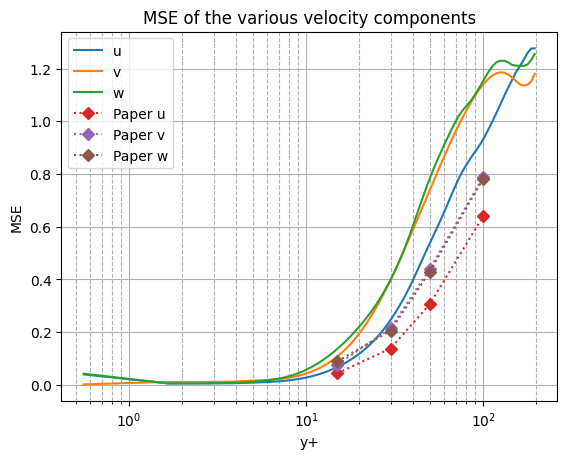

In [24]:
import matplotlib.pyplot as plt
y_dim = dataset.channel.get_simulation_channel().y_dimension[:64] * 200

plt.semilogx(y_dim, mses[0], label='u')
plt.semilogx(y_dim, mses[1], label='v')
plt.semilogx(y_dim, mses[2], label='w')
# plt.semilogx(y_dim, global_mse, label='avg')
plt.semilogx([15, 30, 50, 100], [0.043, 0.137, 0.306, 0.639], label='Paper u', linestyle=':', marker='D')
plt.semilogx([15, 30, 50, 100], [0.076, 0.214, 0.440, 0.788], label='Paper v', linestyle=':', marker='D')
plt.semilogx([15, 30, 50, 100], [0.088, 0.205, 0.429, 0.782], label='Paper w', linestyle=':', marker='D')
plt.title("MSE of the various velocity components")
plt.xlabel("y+")
plt.ylabel("MSE")
plt.grid()
plt.grid(which='minor', linestyle='--')
plt.legend()